In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

Use only feature 'Adj Close'

In [189]:
start = '2000-01-01'
end = datetime(2024, 8, 7, 11, 21, 24, 633194)

sp500_data = yf.download('^GSPC', start='2000-03-14', end='2024-01-01')
sp500 = sp500_data.dropna()
print(sp500.head(3))

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-03-14  1383.619995  1395.150024  1359.150024  1359.150024  1359.150024   
2000-03-15  1359.150024  1397.989990  1356.989990  1392.140015  1392.140015   
2000-03-16  1392.150024  1458.469971  1392.150024  1458.469971  1458.469971   

                Volume  
Date                    
2000-03-14  1094000000  
2000-03-15  1302800000  
2000-03-16  1482300000  


In [190]:
data = sp500.filter(['Adj Close'])
#convert the dataframe to a numpy array
dataset = data.values
train_data_len = int(np.round(0.8 * dataset.shape[0]))
train_data_len

4790

In [191]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:train_data_len, :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
#reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(4730, 60, 1)

In [192]:
test_data = scaled_data[train_data_len - 60:, :]
x_test = []
y_test = dataset[train_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test= np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(1198, 60, 1)

In [193]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4730, 60, 1), (4730,), (1198, 60, 1), (1198, 1))

In [194]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf


tf.random.set_seed(42)
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
1892/1892 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - loss: 1.6113e-04 - val_loss: 5.6176e-05
Epoch 2/2
1892/1892 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 5.5380e-05 - val_loss: 6.3414e-05


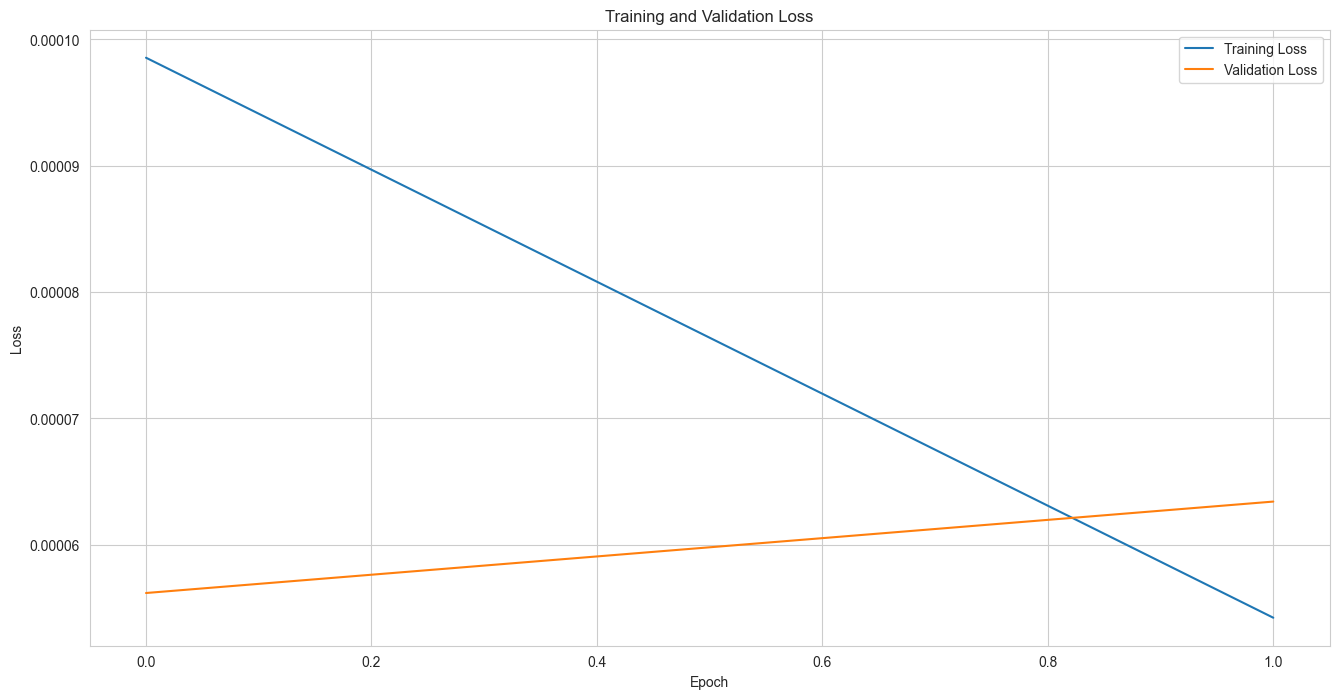

In [195]:
history=model.fit(x_train,y_train,epochs=2,batch_size=2,validation_split=0.2)

# Plot the training and validation loss
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [196]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
#get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


98.36658917400077

We can see both from our rmse and the train validation loss mour model here did a terriable job, however, when look at the model below, it looks we get a good resutls anyway. 

/var/folders/py/r18r2psx509b19yt58bj8b300000gn/T/ipykernel_56829/3729137219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


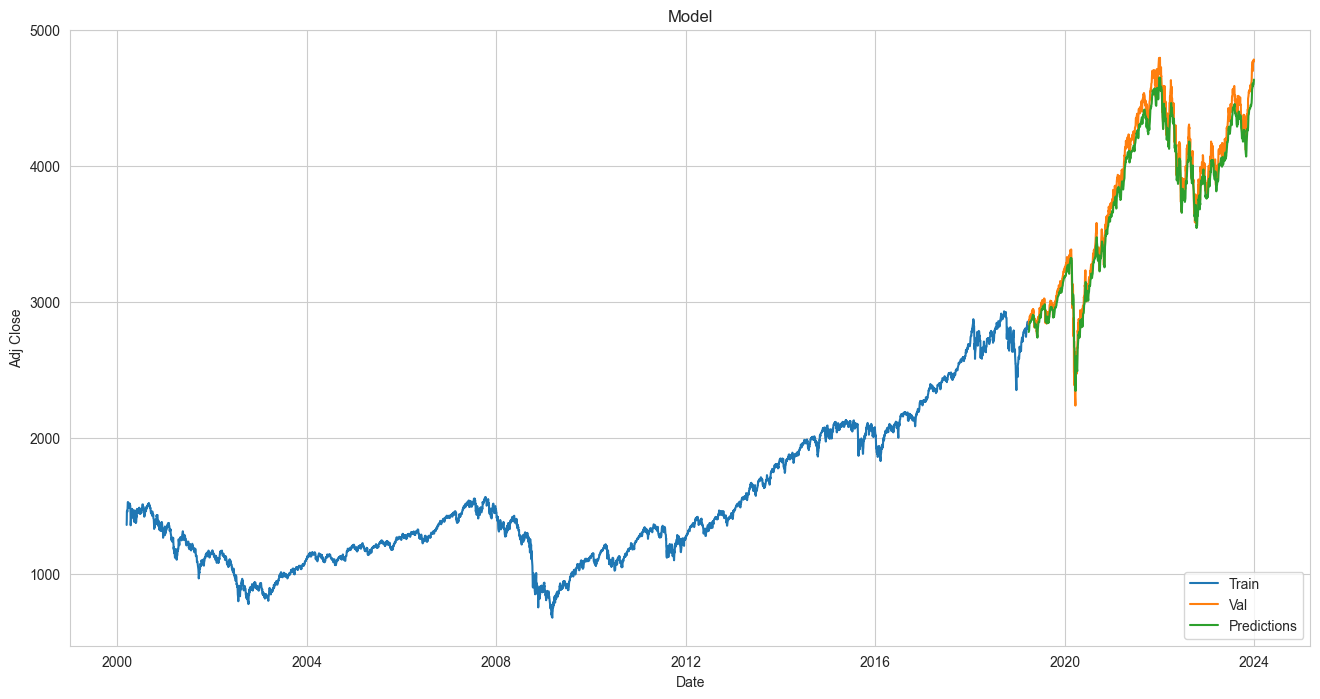

In [197]:
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

/var/folders/py/r18r2psx509b19yt58bj8b300000gn/T/ipykernel_56829/1264031377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


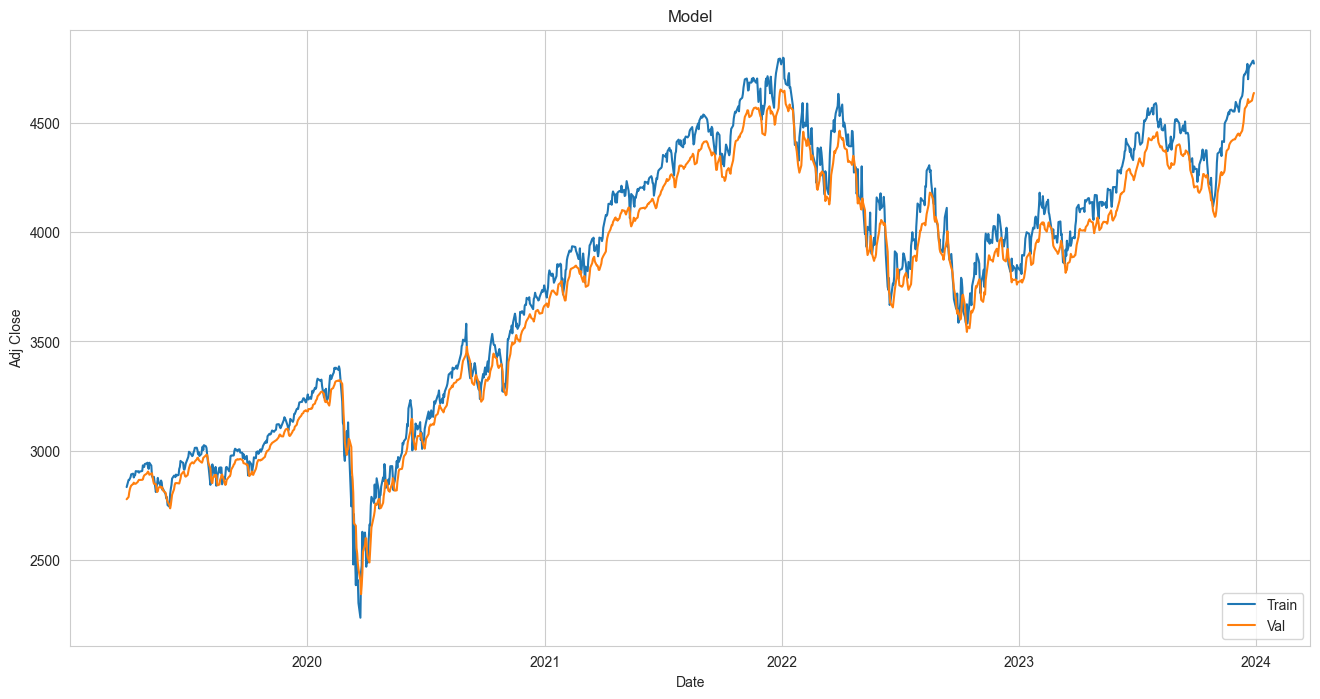

In [198]:
valid = data[train_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

Our goal is long term investment

We can see although both the rmse and the train validation loss are high, the model is still able to predict the trend of the stock price. This is because the model is able to predict the stock price of the next day near to the current day price. This is not useful in real life.

Now let's add more features 

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime


tech_list = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'GOOG'] #^GSPC is the S&P 500

end = datetime(2024, 8, 7, 11, 21, 24, 633194)
start = datetime(end.year - 1, end.month, end.day)

# Downloading data for each stock and storing it in a dictionary
stock_data = {}
for stock in tech_list:
    stock_data[stock] = yf.download(stock, start, end)


for stock in stock_data:
    stock_data[stock].rename(columns={"Adj Close": "Adjusted Close"}, inplace=True)

# Assigning each DataFrame to a variable for convenience
SP500 = stock_data['^GSPC']
AAPL = stock_data['AAPL']
MSFT = stock_data['MSFT']
AMZN = stock_data['AMZN']
NVDA = stock_data['NVDA']
GOOGL = stock_data['GOOGL']
TSLA = stock_data['TSLA']
GOOG = stock_data['GOOG']

# Adding company_name to each DataFrame and concatenating them
company_list = [SP500, AAPL, MSFT, AMZN, NVDA, GOOGL, TSLA, GOOG]
company_name = ["SP500", "APPLE", "MICROSOFT", "AMAZON", "NVIDIA", "GOOGLE", "TESLA", "ALPHABET"]

for df, com_name in zip(company_list, company_name):
    df["company_name"] = com_name

# Concatenating all DataFrames
df = pd.concat(company_list, axis=0)

print(df['company_name'].unique())
print(df.tail(10))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

['SP500' 'APPLE' 'MICROSOFT' 'AMAZON' 'NVIDIA' 'GOOGLE' 'TESLA' 'ALPHABET']
                  Open        High         Low       Close  Adjusted Close  \
Date                                                                         
2024-07-25  174.250000  175.199997  169.050003  169.160004      169.160004   
2024-07-26  168.770004  169.839996  165.865005  168.679993      168.679993   
2024-07-29  170.500000  172.160004  169.720001  171.130005      171.130005   
2024-07-30  171.830002  172.949997  170.119995  171.860001      171.860001   
2024-07-31  174.919998  175.910004  171.720001  173.149994      173.149994   
2024-08-01  171.979996  175.679993  170.509995  172.449997      172.449997   
2024-08-02  168.190002  170.210007  166.389999  168.399994      168.399994   
2024-08-05  157.369995  165.940002  156.600006  160.639999      160.639999   
2024-08-06  160.945007  162.350006  158.130005  160.539993      160.539993   
2024-08-07  163.240005  164.789993  160.240005  160.750000      16

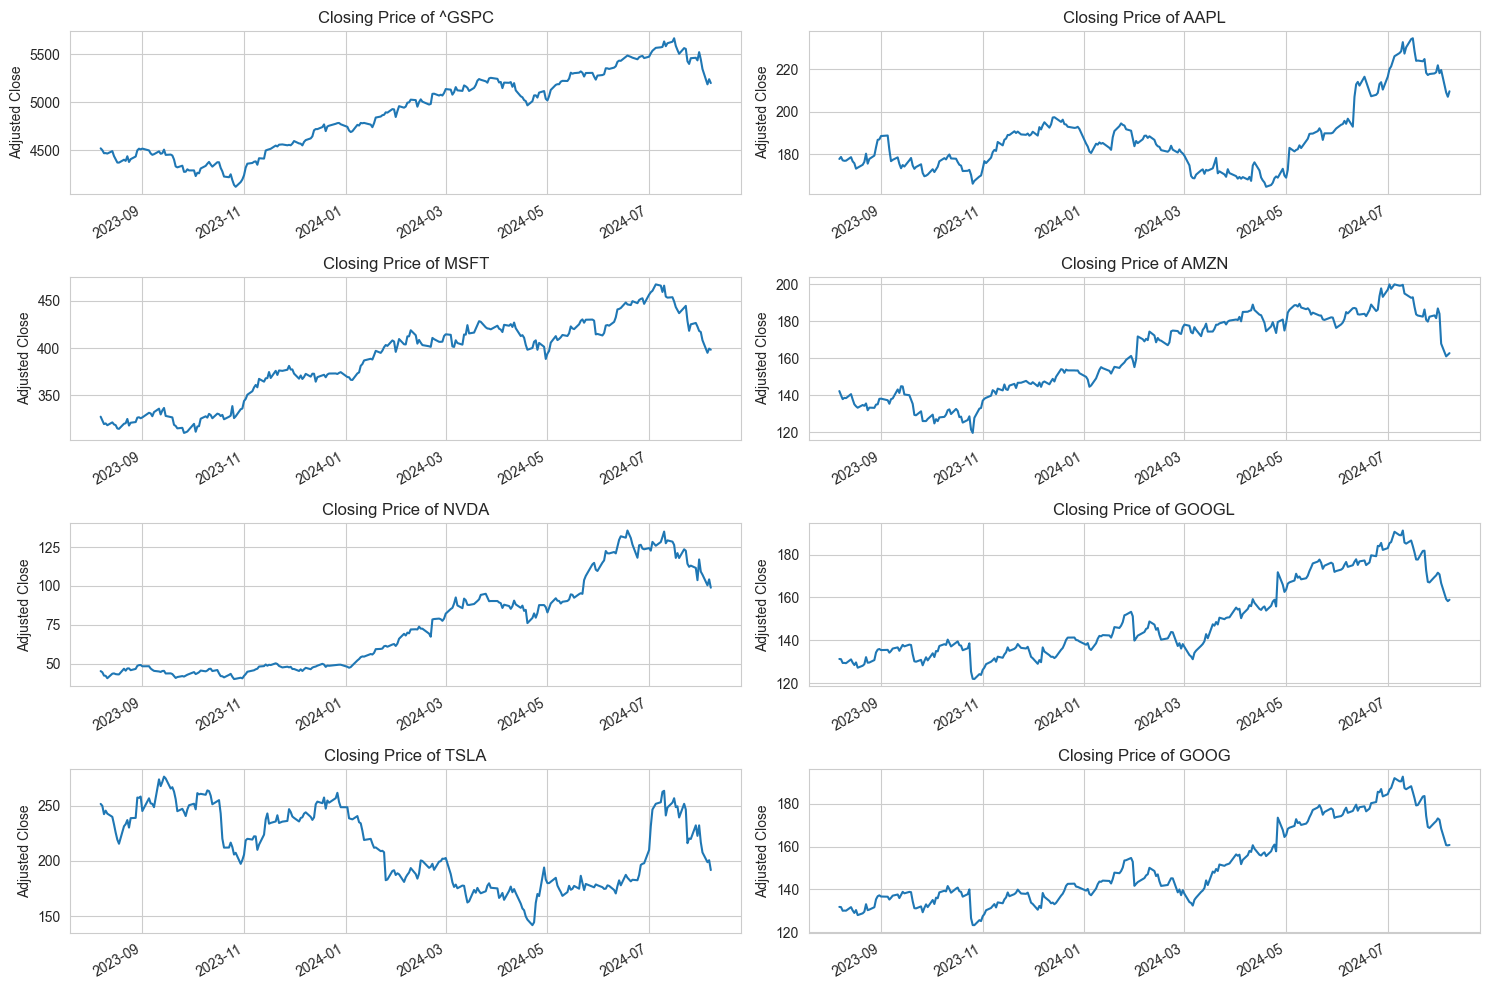

In [200]:

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(4, 2, i)
    company['Adjusted Close'].plot()
    plt.ylabel('Adjusted Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

All three stocks (Apple, Microsoft, Amazon) and the S&P 500 index display a general upward trend from around November 2023 to June 2024.

Each of the stocks, along with the S&P 500, reached their respective peaks around July 2024.

After peaking, all three stocks and the S&P 500 index experienced a notable decline.

Notice: Microsoft has the most similar trend to the S&P 500 index.

[*********************100%%**********************]  8 of 8 completed


Text(0.5, 1.0, 'Correlation of stock closing price')

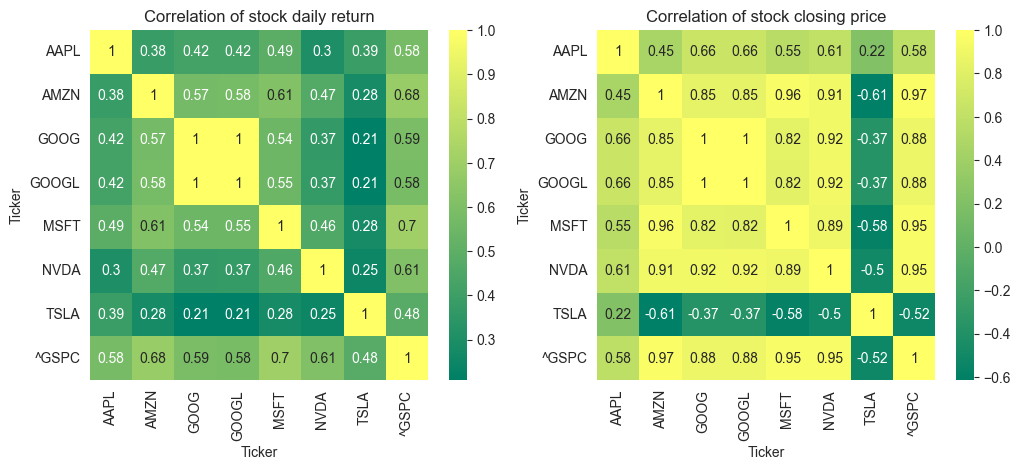

In [201]:
import seaborn as sns

# Fetch the adjusted closing prices for the tech stocks
tickers = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'GOOGL', 'TSLA', 'GOOG', '^GSPC']
closing_df = yf.download(tickers, start=start, end=end)['Adj Close']
# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()


plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock daily return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

In [232]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

end = datetime(2024, 8, 7, 11, 21, 24, 633194)
start = '2000-01-01'

# Fetch daily S&P 500 data
sp500_data = yf.download('^GSPC', start=start, end=end)


# Add technical indicators
sp500_data['Rsi'] = ta.rsi(sp500_data['Adj Close'], length=14)  
sp500_data['Ema_fast'] = ta.ema(sp500_data['Adj Close'], length=12)  
sp500_data['Ema_medium'] = ta.ema(sp500_data['Adj Close'], length=26)  
sp500_data['Ema_slow'] = ta.ema(sp500_data['Adj Close'], length=50) 
sp500_data['Sma_30'] = ta.sma(sp500_data['Adj Close'], length=30)  
sp500_data['Sma_100'] = ta.sma(sp500_data['Adj Close'], length=100)  

sp500_data['Bollinger_High'] = ta.bbands(sp500_data['Adj Close'], length=20, std=2)['BBU_20_2.0']
sp500_data['Bollinger_Low'] = ta.bbands(sp500_data['Adj Close'], length=20, std=2)['BBL_20_2.0']

sp500_data['ATR'] = ta.atr(sp500_data['High'], sp500_data['Low'], sp500_data['Adj Close'], length=14)
sp500_data['MACD'] = ta.macd(sp500_data['Adj Close'], fast=12, slow=26, signal=9)['MACD_12_26_9']

print(sp500_data.head())

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971  1455.219971   
2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1399.420044   
2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1402.109985   
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1403.449951   
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1441.469971   

                Volume  Rsi  Ema_fast  Ema_medium  Ema_slow  Sma_30  Sma_100  \
Date                                                                           
2000-01-03   931800000  NaN       NaN         NaN       NaN     NaN      NaN   
2000-01-04  1009000000  NaN       NaN         NaN       NaN     NaN      NaN   
2000-01-05  1085500000  NaN       NaN         NaN       NaN     NaN      NaN   
2000-01-06  1092300000  NaN       NaN         

We can see that our target is correlated with the daily return of these stock. 

In [233]:
import pandas as pd
import yfinance as yf
from datetime import datetime


# Fetch adjusted close prices for Apple, Amazon, and Microsoft...
tickers = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'GOOGL', 'TSLA', 'GOOG']
data = {}

for ticker in tickers:
    stock_data = yf.download(ticker, start=start, end=end)
    adj_close = stock_data['Adj Close']
    data[ticker] = adj_close.rename(ticker)

# Merge the data into a single DataFrame
merged_data = pd.concat(data.values(), axis=1)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [234]:
merged_data.dropna(inplace=True)

for column in merged_data.columns:
    merged_data[f'{column} DR'] = merged_data[column].pct_change()

merged_data.dropna(inplace=True)

print(merged_data.head())


                AAPL    AMZN       MSFT      NVDA      GOOGL      TSLA  \
Date                                                                     
2010-06-30  7.586102  5.4630  17.549168  0.234122  11.122120  1.588667   
2010-07-01  7.494112  5.5480  17.663572  0.238020  10.985640  1.464000   
2010-07-02  7.447665  5.4570  17.747459  0.235039  10.912151  1.280000   
2010-07-06  7.498643  5.5030  18.166931  0.232517  10.900153  1.074000   
2010-07-07  7.801444  5.6715  18.533016  0.243753  11.253350  1.053333   

                 GOOG   AAPL DR   AMZN DR   MSFT DR   NVDA DR  GOOGL DR  \
Date                                                                      
2010-06-30  11.069613 -0.018113  0.005985 -0.012870 -0.025763 -0.020495   
2010-07-01  10.933779 -0.012126  0.015559  0.006519  0.016650 -0.012271   
2010-07-02  10.860637 -0.006198 -0.016402  0.004749 -0.012524 -0.006689   
2010-07-06  10.848695  0.006845  0.008430  0.023636 -0.010731 -0.001100   
2010-07-07  11.200226  0.040381

In [235]:
columns_to_drop = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'GOOGL', 'TSLA', 'GOOG']
data = {}

merged_data.drop(columns=columns_to_drop, inplace=True)

print(merged_data.head())

             AAPL DR   AMZN DR   MSFT DR   NVDA DR  GOOGL DR   TSLA DR  \
Date                                                                     
2010-06-30 -0.018113  0.005985 -0.012870 -0.025763 -0.020495 -0.002511   
2010-07-01 -0.012126  0.015559  0.006519  0.016650 -0.012271 -0.078473   
2010-07-02 -0.006198 -0.016402  0.004749 -0.012524 -0.006689 -0.125683   
2010-07-06  0.006845  0.008430  0.023636 -0.010731 -0.001100 -0.160937   
2010-07-07  0.040381  0.030620  0.020151  0.048323  0.032403 -0.019243   

             GOOG DR  
Date                  
2010-06-30 -0.020495  
2010-07-01 -0.012271  
2010-07-02 -0.006690  
2010-07-06 -0.001100  
2010-07-07  0.032403  


In [236]:
merged_data = pd.concat([sp500_data, merged_data], axis=1).dropna()

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3550 entries, 2010-06-30 to 2024-08-07
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            3550 non-null   float64
 1   High            3550 non-null   float64
 2   Low             3550 non-null   float64
 3   Close           3550 non-null   float64
 4   Adj Close       3550 non-null   float64
 5   Volume          3550 non-null   int64  
 6   Rsi             3550 non-null   float64
 7   Ema_fast        3550 non-null   float64
 8   Ema_medium      3550 non-null   float64
 9   Ema_slow        3550 non-null   float64
 10  Sma_30          3550 non-null   float64
 11  Sma_100         3550 non-null   float64
 12  Bollinger_High  3550 non-null   float64
 13  Bollinger_Low   3550 non-null   float64
 14  ATR             3550 non-null   float64
 15  MACD            3550 non-null   float64
 16  AAPL DR         3550 non-null   float64
 17  AMZN DR        

let's add some economic features 

In [237]:
# Fetch economic data
gdp = pdr.get_data_fred('GDP', start=start, end=end) #quaterly
inflation = pdr.get_data_fred('CPIAUCSL', start=start, end=end)  # CPI for inflation
unemployment = pdr.get_data_fred('UNRATE', start=start, end=end)
interest_rate = pdr.get_data_fred('FEDFUNDS', start=start, end=end)

# Rename columns for clarity
gdp.rename(columns={'GDP': 'GDP'}, inplace=True)
inflation.rename(columns={'CPIAUCSL': 'Inflation'}, inplace=True)
unemployment.rename(columns={'UNRATE': 'Unemployment'}, inplace=True)
interest_rate.rename(columns={'FEDFUNDS': 'Interest_Rate'}, inplace=True)
GDP = gdp.resample('D').ffill()
Inflation = inflation.resample('D').ffill()
Unemployment = unemployment.resample('D').ffill()
Interest_rate = interest_rate.resample('D').ffill()

merged_data = merged_data.join([Inflation, Unemployment, Interest_rate, GDP], how='left')

print(merged_data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Rsi',
       'Ema_fast', 'Ema_medium', 'Ema_slow', 'Sma_30', 'Sma_100',
       'Bollinger_High', 'Bollinger_Low', 'ATR', 'MACD', 'AAPL DR', 'AMZN DR',
       'MSFT DR', 'NVDA DR', 'GOOGL DR', 'TSLA DR', 'GOOG DR', 'Inflation',
       'Unemployment', 'Interest_Rate', 'GDP'],
      dtype='object')


In [238]:
n_lags = 3
for col in ['Adj Close', 'Rsi', 'MACD']:
    for lag in range(1, n_lags + 1):
        merged_data[f'{col}_lag_{lag}'] = merged_data[col].shift(lag)

merged_data['Target'] = merged_data['Adj Close'].pct_change()

merged_data.dropna(inplace=True)
merged_data.reset_index(inplace = True)
Date = merged_data['Date']
merged_data.drop([ 'Date', 'Volume'], axis=1, inplace=True)
print(merged_data.head(3))

          Open         High          Low        Close    Adj Close        Rsi  \
0  1028.089966  1042.500000  1018.349976  1028.060059  1028.060059  32.767748   
1  1028.540039  1060.890015  1028.540039  1060.270020  1060.270020  45.156109   
2  1062.920044  1071.250000  1058.239990  1070.250000  1070.250000  48.332802   

      Ema_fast   Ema_medium     Ema_slow       Sma_30  ...  Adj Close_lag_1  \
0  1055.252067  1076.029172  1097.563245  1077.334996  ...      1022.580017   
1  1056.024059  1074.861827  1096.100766  1076.888995  ...      1028.060059   
2  1058.212666  1074.520210  1095.087010  1076.762994  ...      1060.270020   

   Adj Close_lag_2  Adj Close_lag_3  Rsi_lag_1  Rsi_lag_2  Rsi_lag_3  \
0      1027.369995      1030.709961  30.279730  31.217372  31.856079   
1      1022.580017      1027.369995  32.767748  30.279730  31.217372   
2      1028.060059      1022.580017  45.156109  32.767748  30.279730   

   MACD_lag_1  MACD_lag_2  MACD_lag_3    Target  
0  -19.670632  -17.

<Axes: >

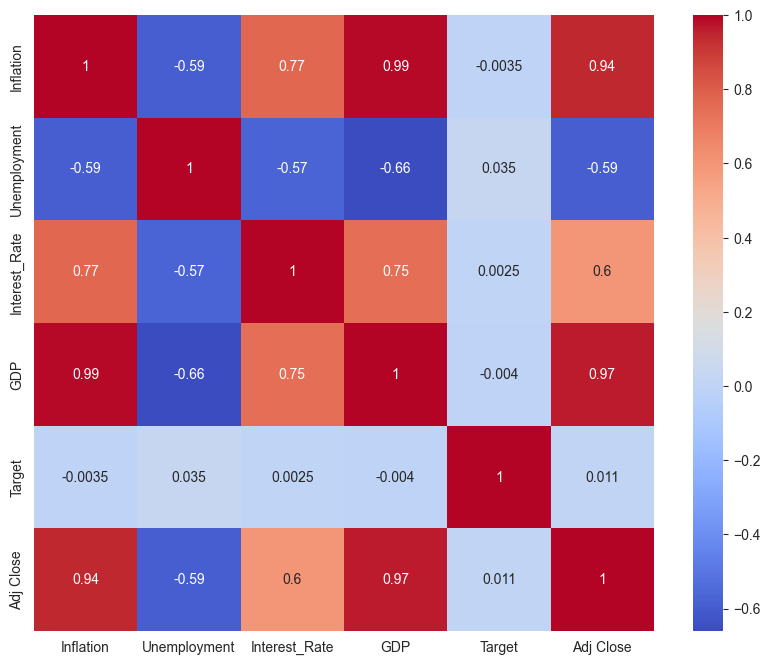

In [239]:
dd = merged_data[['Inflation', 'Unemployment', 'Interest_Rate', 'GDP', 'Target', 'Adj Close']]


import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(dd.corr(), annot=True, cmap='coolwarm')

In [240]:
merged_data.drop(['Inflation', 'Unemployment', 'Interest_Rate', 'GDP'], axis=1, inplace=True)
print(merged_data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Rsi', 'Ema_fast',
       'Ema_medium', 'Ema_slow', 'Sma_30', 'Sma_100', 'Bollinger_High',
       'Bollinger_Low', 'ATR', 'MACD', 'AAPL DR', 'AMZN DR', 'MSFT DR',
       'NVDA DR', 'GOOGL DR', 'TSLA DR', 'GOOG DR', 'Adj Close_lag_1',
       'Adj Close_lag_2', 'Adj Close_lag_3', 'Rsi_lag_1', 'Rsi_lag_2',
       'Rsi_lag_3', 'MACD_lag_1', 'MACD_lag_2', 'MACD_lag_3', 'Target'],
      dtype='object')


In [241]:
features= merged_data.drop(['Target'], axis=1)
features = features.columns
print(features)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Rsi', 'Ema_fast',
       'Ema_medium', 'Ema_slow', 'Sma_30', 'Sma_100', 'Bollinger_High',
       'Bollinger_Low', 'ATR', 'MACD', 'AAPL DR', 'AMZN DR', 'MSFT DR',
       'NVDA DR', 'GOOGL DR', 'TSLA DR', 'GOOG DR', 'Adj Close_lag_1',
       'Adj Close_lag_2', 'Adj Close_lag_3', 'Rsi_lag_1', 'Rsi_lag_2',
       'Rsi_lag_3', 'MACD_lag_1', 'MACD_lag_2', 'MACD_lag_3'],
      dtype='object')


we have too many features, let's perfom pca to reduce the dimensionality of the data.

In [242]:
from sklearn.preprocessing import StandardScaler

x = merged_data.loc[:, features].values
y = merged_data.loc[:,['Target']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [243]:
pd.DataFrame(data = x, columns = features).head()

,Open,High,Low,Close,Adj Close,Rsi,Ema_fast,Ema_medium,Ema_slow,Sma_30,...,GOOG DR,Adj Close_lag_1,Adj Close_lag_2,Adj Close_lag_3,Rsi_lag_1,Rsi_lag_2,Rsi_lag_3,MACD_lag_1,MACD_lag_2,MACD_lag_3
0,-1.465795,-1.457302,-1.469557,-1.466121,-1.466121,-2.043697,-1.440759,-1.420562,-1.397795,-1.418138,...,-0.117281,-1.470775,-1.466040,-1.462631,-2.263661,-2.177838,-2.118851,-0.904396,-0.830440,-0.743801
1,-1.465383,-1.440568,-1.460177,-1.436651,-1.436651,-0.936758,-1.440050,-1.421639,-1.399153,-1.418550,...,1.829241,-1.465758,-1.470427,-1.465691,-2.041491,-2.261520,-2.175825,-0.940429,-0.903940,-0.830003
2,-1.433921,-1.431142,-1.432837,-1.427521,-1.427521,-0.652911,-1.438040,-1.421954,-1.400095,-1.418667,...,0.767393,-1.436273,-1.465408,-1.470081,-0.935262,-2.039470,-2.259464,-0.877273,-0.939983,-0.903525
3,-1.426985,-1.424854,-1.423761,-1.420466,-1.420466,-0.440665,-1.435250,-1.421719,-1.400719,-1.418359,...,1.337526,-1.427138,-1.435908,-1.465059,-0.651597,-0.933836,-2.037528,-0.794874,-0.876810,-0.939579
4,-1.420826,-1.422470,-1.421598,-1.419744,-1.419744,-0.418433,-1.432777,-1.421447,-1.401289,-1.419107,...,0.983115,-1.420080,-1.426768,-1.435543,-0.439487,-0.650324,-0.932464,-0.704236,-0.794388,-0.876387


In [244]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=10)  
principalComponents = pca.fit_transform(x)
pca.explained_variance_ratio_

array([0.50168872, 0.210863  , 0.13721484, 0.03722736, 0.02710949,
       0.02002892, 0.0162636 , 0.01586561, 0.01179782, 0.0095271 ])

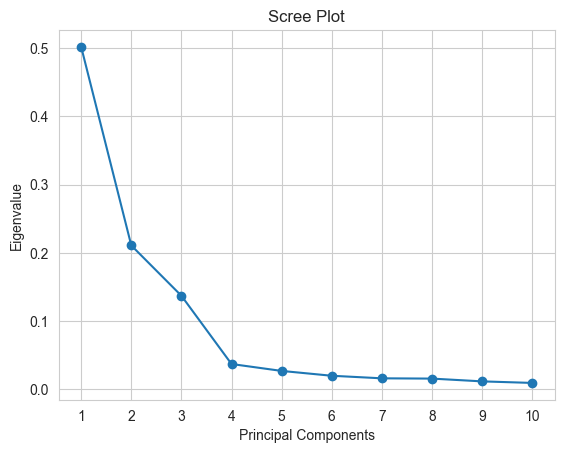

In [245]:
# Explained variance ratio
importance = pca.explained_variance_ratio_

# Scree plot
plt.scatter(range(1, len(importance) + 1), importance)
plt.plot(range(1, len(importance) + 1), importance)
plt.title('Scree Plot')
plt.xlabel('Principal Components')  
plt.ylabel('Eigenvalue') 
plt.xticks(range(1, len(importance) + 1))
plt.grid(True)
plt.show()

In [246]:
pca = PCA(n_components=3)  # Adjust this number to the total number of components you want to analyze
principalComponents = pca.fit_transform(x)
print(sum(pca.explained_variance_ratio_))

0.8497665695680383


by look at the ratio and the plot, 3 principal components can explain 84% of the variance in the data.

In [247]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3'])
finalDf = pd.concat([principalDf, merged_data[['Target']]], axis = 1)
finalDf.head(5)

,PC1,PC2,PC3,Target
0,-5.860558,-3.712898,-0.656220,0.005359
1,-5.841506,-3.204736,3.893116,0.031331
2,-5.802315,-2.723477,1.545865,0.009413
3,-5.729781,-2.043893,1.300548,0.007204
4,-5.669946,-1.385848,1.581688,0.000733


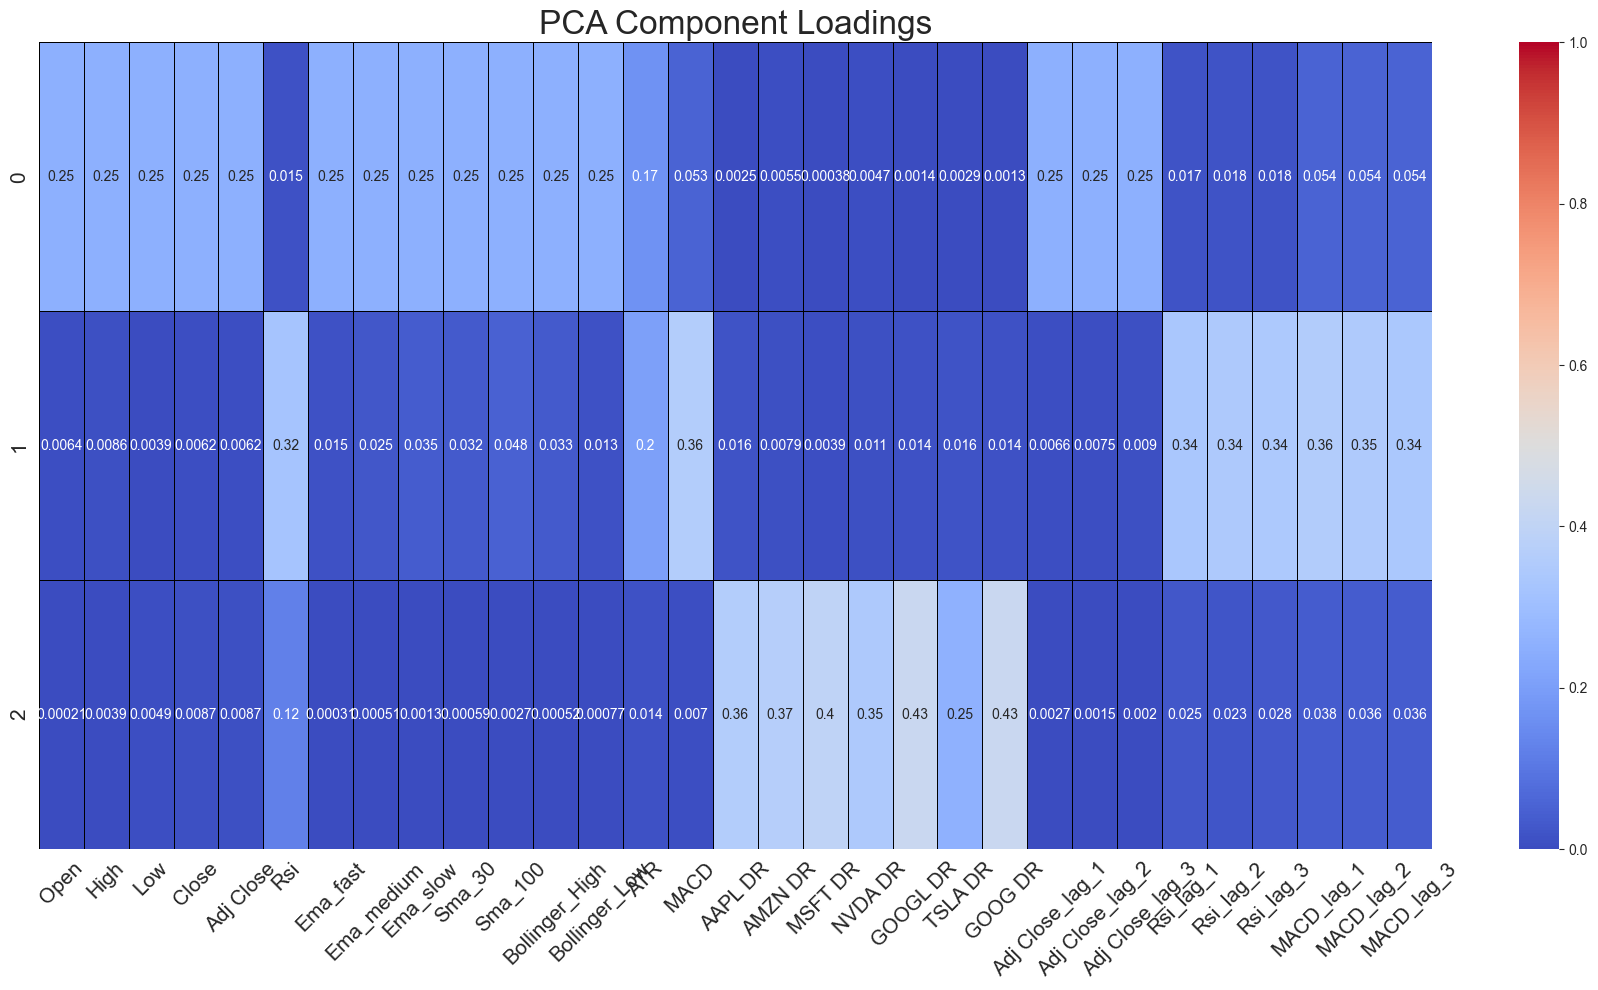

In [248]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


df_cm = pd.DataFrame(np.abs(pca.components_), columns=merged_data.columns[:-1])
plt.figure(figsize=(18, 10))  # Increase figure size 
ax = sns.heatmap(df_cm, annot=True, cmap="coolwarm", linewidths=0.5, linecolor='black', vmin=0, vmax=1, annot_kws={"size": 10})
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15, rotation=45) 
plt.title('PCA Component Loadings', fontsize=24)
plt.tight_layout()  
plt.savefig('factorAnalysis_improved.png', dpi=300) 
plt.show() 


let's now perform LSTM on the data and see how it performs.

In [249]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data_set_scaled = sc.fit_transform(finalDf)
print(data_set_scaled)

[[-1.48607587 -1.45221846 -0.31817646  0.4426513 ]
 [-1.4812446  -1.25346195  1.88762587  2.82459137]
 [-1.47130705 -1.06522843  0.74953198  0.81442157]
 ...
 [ 2.37142648  1.0824967   0.10096184  0.74269757]
 [ 2.37964639  1.05829796 -0.24226336  0.05355604]
 [ 2.37987217  1.07974464  0.62749069 -0.23351087]]


standardizes only the feature columns (excluding the target column).
excludes the target column when preparing sequences for LSTM, ensuring that the LSTM inputs consist solely of features.
avoid data leaking 

In [250]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

splitlimit = int(finalDf.shape[0] * 0.8)
trainDf, testDf = finalDf[:splitlimit], finalDf[splitlimit:]

# Standardize the data excluding the target column 
sc = StandardScaler()
trainDf_scaled = sc.fit_transform(trainDf.iloc[:, :-1])#exclude the target column
testDf_scaled = sc.transform(testDf.iloc[:, :-1])

# Prepare the sequences for LSTM
backcandles = 30


X_train = []
X_test = []

for j in range(trainDf_scaled.shape[1]):  # loop over features
    temp_train = []
    for i in range(backcandles, len(trainDf_scaled)):
        temp_train.append(trainDf_scaled[i-backcandles:i, j])
    X_train.append(temp_train)


for j in range(testDf_scaled.shape[1]):  # loop over features
    temp_test = []
    for i in range(backcandles, len(testDf_scaled)):
        temp_test.append(testDf_scaled[i-backcandles:i, j])
    X_test.append(temp_test)

# Convert lists to numpy arrays and move axes
X_train = np.moveaxis(np.array(X_train), 0, 2)
X_test = np.moveaxis(np.array(X_test), 0, 2)

# Extract target variables assuming target is in the last column
y_train = np.array(trainDf.iloc[backcandles:, -1])
y_test = np.array(testDf.iloc[backcandles:, -1])

# Reshape targets to (samples, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Output shapes for verification
print("Training Data Shape:", X_train.shape)
print("Training Target Shape:", y_train.shape)
print("Test Data Shape:", X_test.shape)
print("Test Target Shape:", y_test.shape)


Training Data Shape: (2736, 30, 3)
Training Target Shape: (2736, 1)
Test Data Shape: (662, 30, 3)
Test Target Shape: (662, 1)


grid search, we dont have enough menmory to run this, we run the random instead

In [221]:
from keras.layers import Dense, LSTM, Dropout, Input
from keras.models import Sequential
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
import numpy as np

tf.random.set_seed(42)

# Define the model creation function
def create_model(units1=64, units2=64, dropout_rate=0.3, learning_rate=0.0001, 
                 l2_reg=0.02, input_shape=None, **kwargs):
    model = Sequential()
    
    # Input layer with shape
    model.add(Input(shape=input_shape))
     
    # First LSTM layer
    model.add(LSTM(units=units1, return_sequences=True, kernel_regularizer=l2(l2_reg)))
    
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='mse', 
                  metrics=[RootMeanSquaredError(), 'mae'])
    return model

# Wrap the model with KerasRegressor
model = KerasRegressor(
    model=create_model,
    input_shape=(x_grid.shape[1], x_grid.shape[2]),  # pass the input shape here
    verbose=0
)

# Define the grid of hyperparameters to search
param_distributions = {
    'model__units1': [32, 64, 128],  # Number of LSTM units in the first layer
    'model__units2': [16, 32, 64],  # Number of LSTM units in the second layer
    'model__dropout_rate': [0.2, 0.3, 0.4],  # Dropout rate
    'model__learning_rate': [1e-5, 1e-4, 1e-3],  # Learning rate
    'model__l2_reg': [0.01, 0.02, 0.03],  # L2 regularization factor
    'batch_size': [32, 64],  # Batch size
    'epochs': [10, 20]  # Number of epochs
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings that are sampled
    cv=3,  # Number of folds for cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search_result = random_search.fit(X_train, y_train)

# Output the best score and parameters
print(f"Best: {random_search_result.best_score_} using {random_search_result.best_params_}")

# Refit the model with the best parameters
best_model = random_search_result.best_estimator_.model_

# Evaluate the best model on the test set
test_loss, test_rmse, test_mae = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test RMSE: {test_rmse}, Test MAE: {test_mae}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


2024-08-14 15:54:03.167813: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-14 15:54:03.167942: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-14 15:54:03.168304: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-14 15:54:03.168362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-14 15:54:03.168611: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-08-14 15:54:03.168625: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-14 15:54:03.168678: I metal_plugin/src/device/metal_device.cc:296] system

[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2, model__l2_reg=0.03, model__learning_rate=0.0001, model__units1=128, model__units2=32; total time=  50.6s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2, model__l2_reg=0.03, model__learning_rate=0.0001, model__units1=128, model__units2=32; total time=  50.7s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3, model__l2_reg=0.02, model__learning_rate=0.001, model__units1=32, model__units2=16; total time=  52.7s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.2, model__l2_reg=0.02, model__learning_rate=0.0001, model__units1=32, model__units2=64; total time=  53.0s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3, model__l2_reg=0.02, model__learning_rate=0.001, model__units1=32, model__units2=16; total time=  53.2s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.2, model__l2_reg=0.02, model__learning_rate=0.0001, model__units1=32, model__units2=64; total time=  55.2s
[CV] END batch_s

Best: -0.001568747604180835 using {'model__units2': 64, 'model__units1': 64, 'model__learning_rate': 0.001, 'model__l2_reg': 0.03, 'model__dropout_rate': 0.3, 'epochs': 10, 'batch_size': 64}

/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 1.8306 - mean_absolute_error: 0.0445 - root_mean_squared_error: 0.0617 - val_loss: 0.9586 - val_mean_absolute_error: 0.0107 - val_root_mean_squared_error: 0.0177 - learning_rate: 0.0010
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7807 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0177 - val_loss: 0.3781 - val_mean_absolute_error: 0.0102 - val_root_mean_squared_error: 0.0163 - learning_rate: 0.0010
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3022 - mean_absolute_error: 0.0081 - root_mean_squared_error: 0.0111 - val_loss: 0.1361 - val_mean_absolute_error: 0.0095 - val_root_mean_squared_error: 0.0160 - learning_rate: 0.0010
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1066 - mean_absolute_error: 0.0069 - root_mean_squared_error: 0.0097 - val_loss: 0.0444 - val_mean_absolute_error: 0.0094 - val_root_mean_squared_error: 0.0159 - learning_rate: 0.0010
Epoch 5/100
35/3

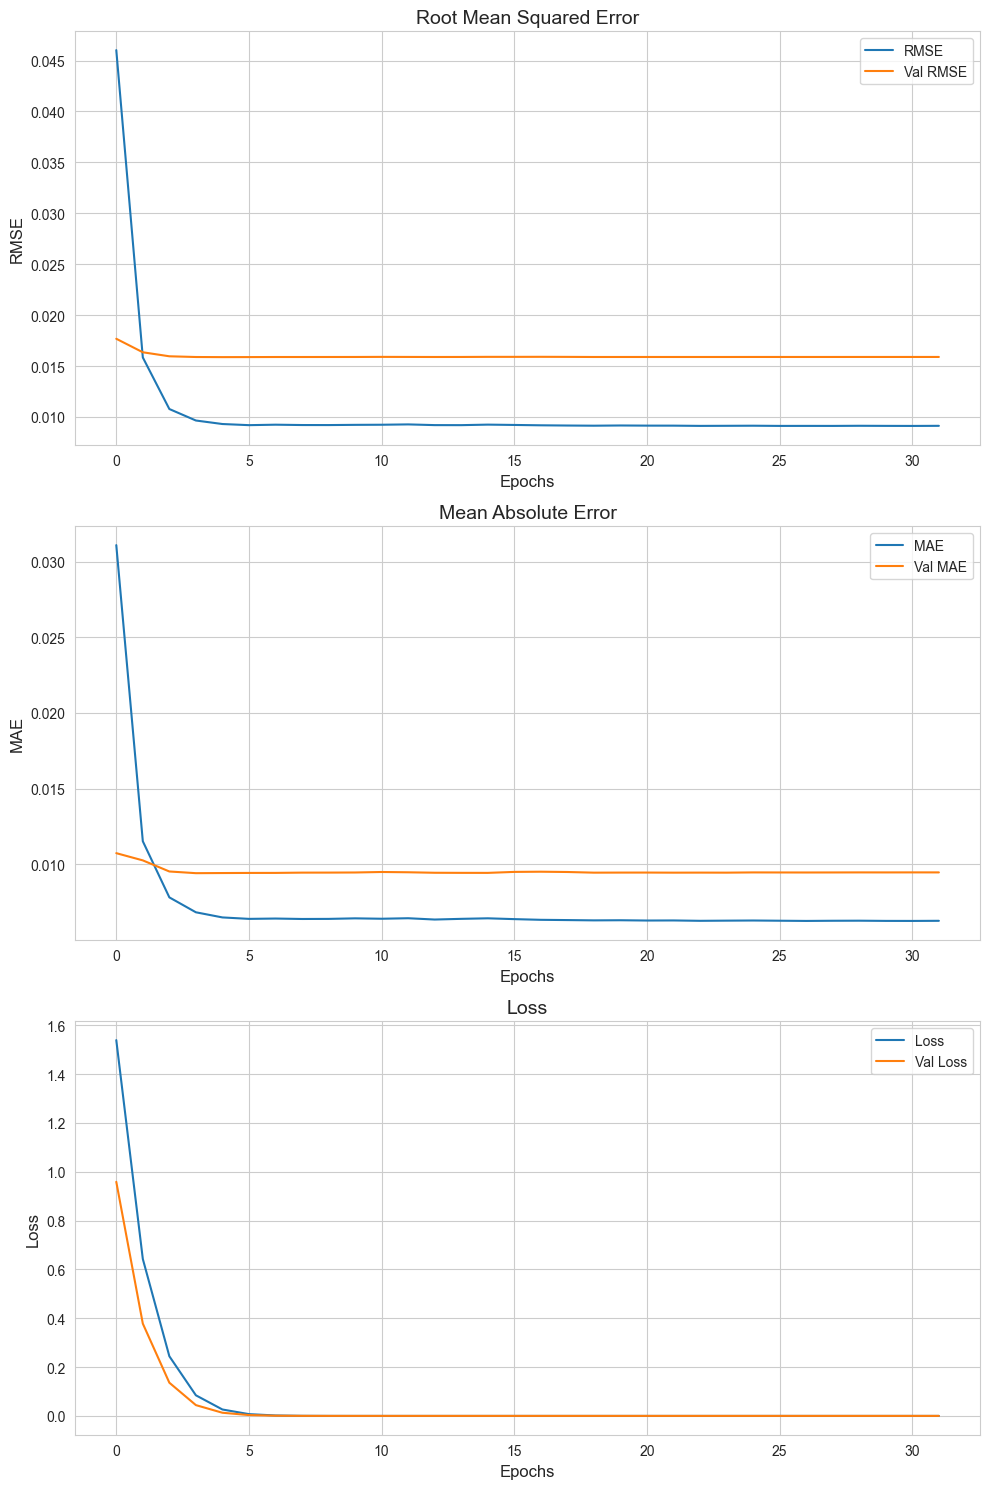

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3792e-04 - mean_absolute_error: 0.0088 - root_mean_squared_error: 0.0116
Test Loss: 0.00012869278725702316, Test RMSE: 0.011344133876264095, Test MAE: 0.008458251133561134


In [251]:
tf.random.set_seed(123)

# Define the model
model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), 
         kernel_regularizer=l2(0.02)),  
    Dropout(0.3),  
    LSTM(units=64, kernel_regularizer=l2(0.02)),
    Dropout(0.3),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),  
              loss='mse', 
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

# Callbacks for early stopping, model checkpointing, and learning rate reduction
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)  
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)  

# Fit the model with callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=64,  # Increased epochs to leverage EarlyStopping
                    validation_split=0.2,
                    callbacks=[es, model_checkpoint, reduce_lr])

# Load the best model based on validation loss
model.load_weights('best_model.keras')

# Plotting the RMSE, MAE, and Loss
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# RMSE plot
ax1.plot(history.epoch, history.history['root_mean_squared_error'], label="RMSE")
ax1.plot(history.epoch, history.history['val_root_mean_squared_error'], label="Val RMSE")
ax1.set_title("Root Mean Squared Error", fontsize=14)
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("RMSE", fontsize=12)
ax1.legend()
ax1.grid(True)

# MAE plot
ax2.plot(history.epoch, history.history['mean_absolute_error'], label="MAE")
ax2.plot(history.epoch, history.history['val_mean_absolute_error'], label="Val MAE")
ax2.set_title("Mean Absolute Error", fontsize=14)
ax2.set_xlabel("Epochs", fontsize=12)
ax2.set_ylabel("MAE", fontsize=12)
ax2.legend()
ax2.grid(True)

# Loss plot
ax3.plot(history.epoch, history.history['loss'], label="Loss")
ax3.plot(history.epoch, history.history['val_loss'], label="Val Loss")
ax3.set_title("Loss", fontsize=14)
ax3.set_xlabel("Epochs", fontsize=12)
ax3.set_ylabel("Loss", fontsize=12)
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on the test set
test_loss, test_rmse, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test RMSE: {test_rmse}, Test MAE: {test_mae}")


In [252]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
[0.00074619] [0.00414638]
[0.00074619] [0.00160731]
[0.00074619] [0.00262085]
[0.00074618] [-0.0070607]
[0.0007462] [-0.01074847]
[0.0007462] [0.00125669]
[0.00074618] [0.00814157]
[0.00074618] [0.00852379]
[0.00074618] [0.00149574]
[0.00074618] [0.00222012]


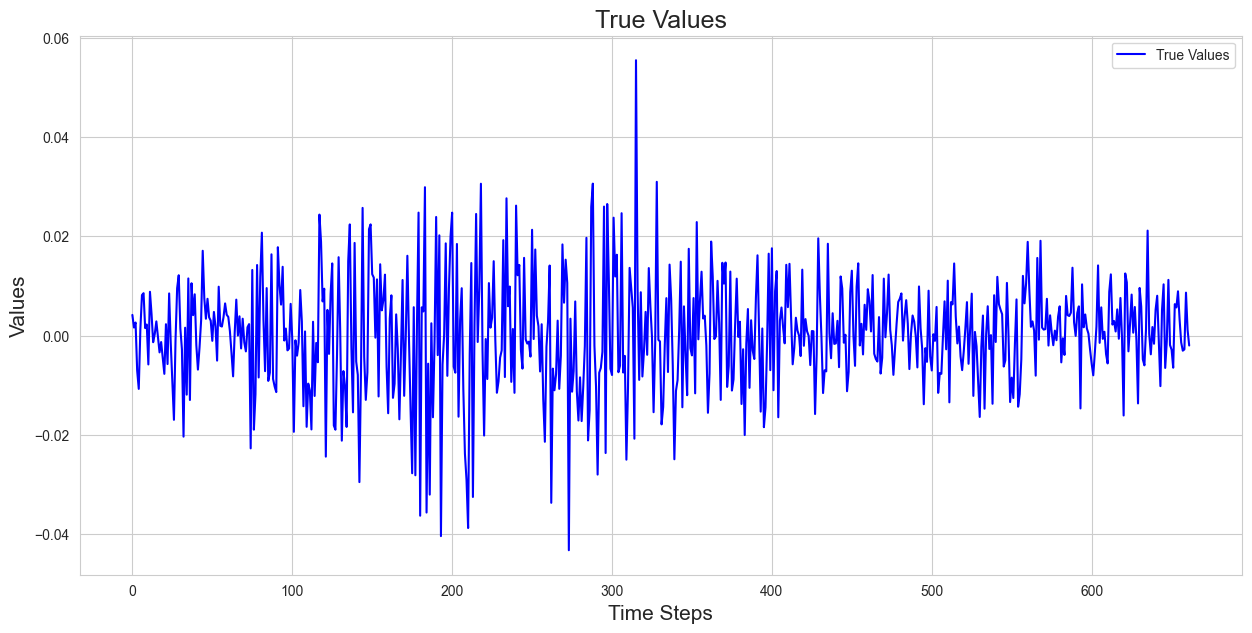

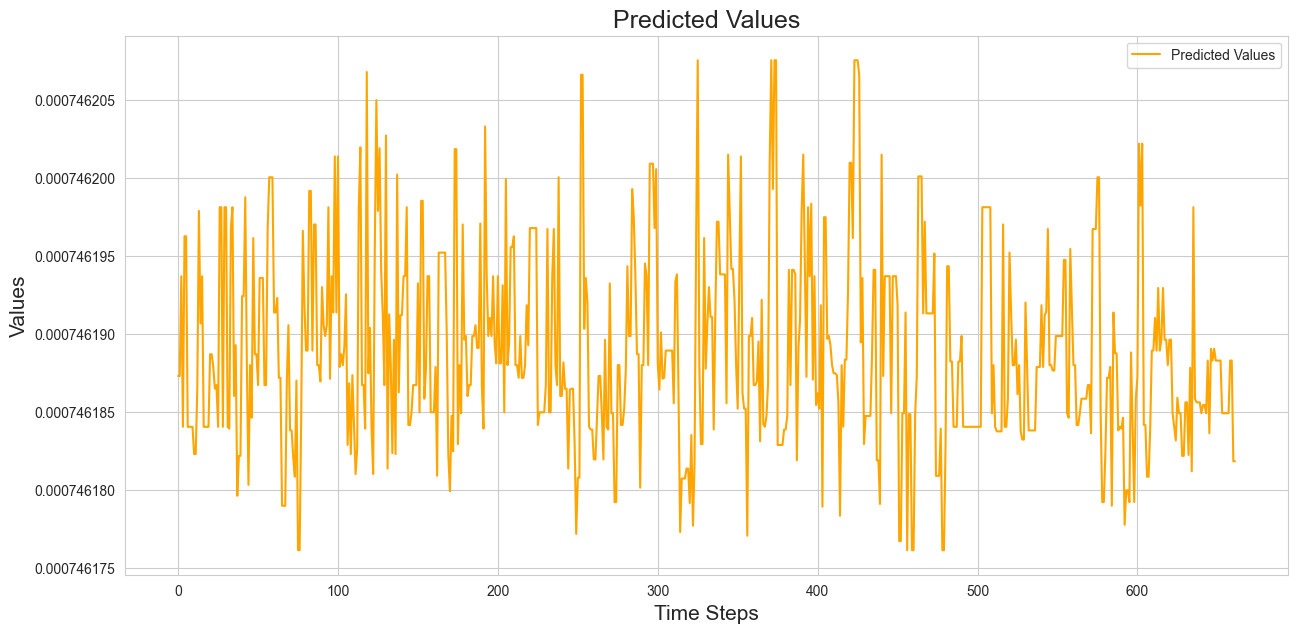

In [253]:
# Flatten the arrays 
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Plot True Values
plt.figure(figsize=(15, 7))
plt.plot(y_test_flat, label='True Values', color='blue')
plt.title('True Values', fontsize=18)
plt.xlabel('Time Steps', fontsize=15)
plt.ylabel('Values', fontsize=15)
plt.grid(True)
plt.legend()
plt.show()

# Plot Predicted Values
plt.figure(figsize=(15, 7))
plt.plot(y_pred_flat, label='Predicted Values', color='orange')
plt.title('Predicted Values', fontsize=18)
plt.xlabel('Time Steps', fontsize=15)
plt.ylabel('Values', fontsize=15)
plt.grid(True)
plt.legend()
plt.show()


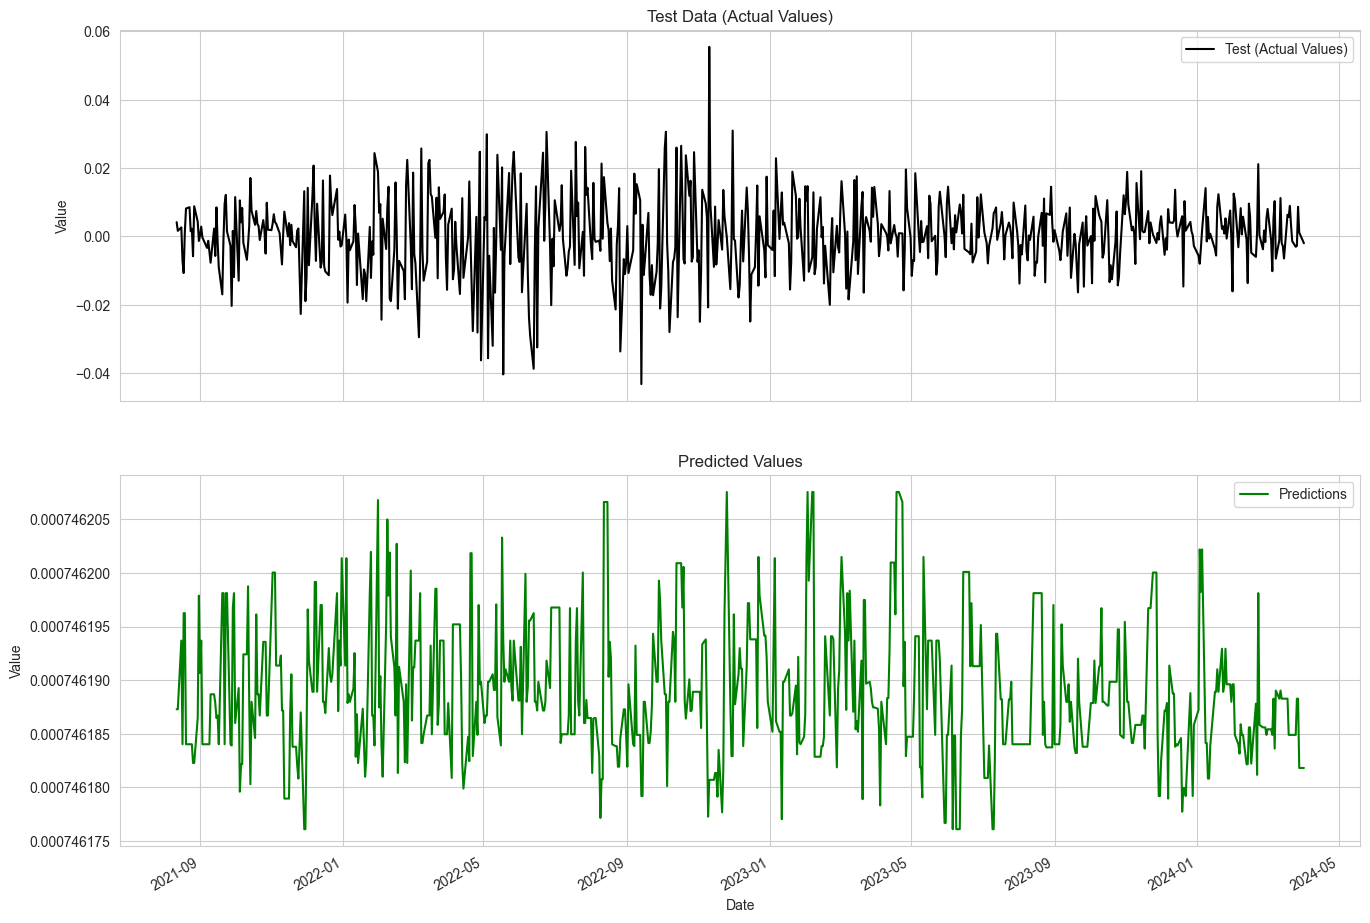

In [254]:
import matplotlib.pyplot as plt

# Adjust the dates to match the length of y_test and y_pred
adjusted_dates = Date[splitlimit + backcandles:]  # Skip the first `backcandles` dates

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(16, 12))  # 2 rows, 1 column

# Plot the test (actual) values in the first subplot with real dates
axs[0].plot(adjusted_dates, y_test, color='black', label='Test (Actual Values)')
axs[0].set_title('Test Data (Actual Values)')
axs[0].legend()
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Value')

# Plot the predicted values in the second subplot with real dates
axs[1].plot(adjusted_dates, y_pred, color='green', label='Predictions')
axs[1].set_title('Predicted Values')
axs[1].legend()
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Value')

# Improve the date formatting on the x-axis
plt.gcf().autofmt_xdate()

# Show the plot
plt.show()


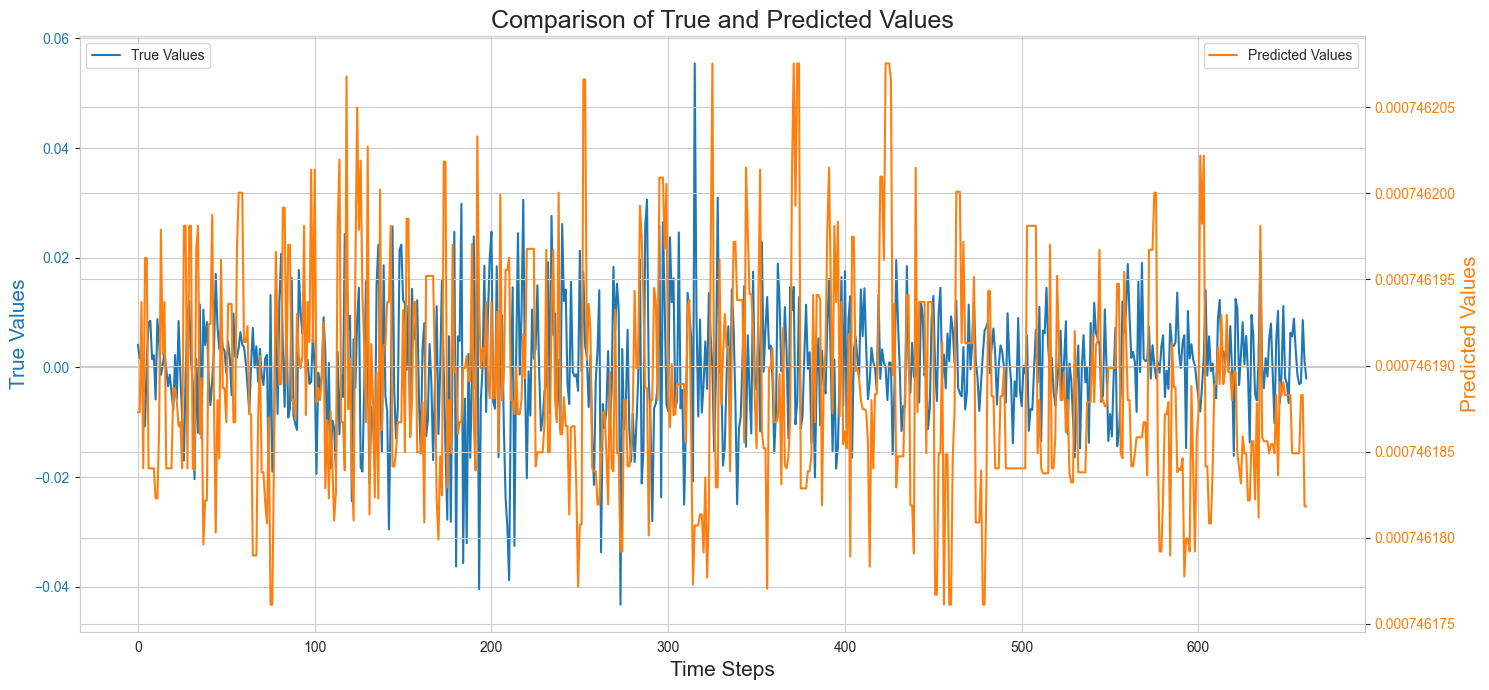

In [256]:
# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot True Values on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Time Steps', fontsize=15)
ax1.set_ylabel('True Values', color=color, fontsize=15)
ax1.plot(y_test_flat, color=color, label='True Values')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)
ax1.legend(loc='upper left')

# Create a second y-axis for the predicted values
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('Predicted Values', color=color, fontsize=15)  # we already handled the x-label with ax1
ax2.plot(y_pred_flat, color=color, label='Predicted Values')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Final touches
plt.title('Comparison of True and Predicted Values', fontsize=18)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Applying PCA before an LSTM model can be a double-edged sword. While it might reduce dimensionality and help in some cases, it risks losing important temporal information that the LSTM relies on. 